# Basics of mobile robotics - Group project

### Members of group T39 :
    Julie Böhning                      296023
    Liandro Da Silva Monteiro          352262
    Lucas Sasaki Pereira               316157
    Sophie Lequeu                      376394

## Introduction
This report presents a summary of our project. We first introduce our environment and briefly justify our choices. We then go through 5 sections related to the main blocks of our implementation. In these sections, we explain the chosen methods and theory, demonstrate how the corresponding code works on simulations, and detail the choice of parameters for the real case.
Finally, we bring everything together to apply to the real case and we show a demonstration.

## Table of contents :

* [1. Choices and assumptions about the environment](#first-bullet)
* [2. Camera images and computer vision](#second-bullet)
* [3. Visibility graph and pathfinding](#third-bullet)
* [4. Motion and Thymio's instructions](#fourth-bullet)
* [5. Local avoidance](#fifth-bullet)
* [6. Filtering](#sixth-bullet)
* [7. Complete implementation](#seven-bullet)
* [8. Conclusion](#eight-bullet)
* [Appendix : sources](#appendix-bullet)

## 1. Choices and justifications about the environment <a class="anchor" id="first-bullet"></a>

### a) Base environment : Background, obstacles, goal and Thymio

- Background : white map, dimensions 850mm x 800mm, delimited by 4 QR-codes. The QR-codes allow to identify and crop the area of interest more precisely. The camera must be positioned so as to capture the 4 corners of the map, but doesn't need to be just  above the center of the map. Image processing part will take care of cropping and straightening (deskewing) the image. $\newline$

- Obstacles : black convex polygons, flat (2D-printed). They are assumed to be polygonal to allow the use of the visibility graph technique. The construction of the visibility graph also assumes convex obstacles, and assumes that they are sufficiently far from each other (i.e. when we make them half-Thymio's width bigger, the resulting shapes don't intersect (detailed in section 3)). They are 2D (not 3D), to distinguish from temporary local obstacles. Being flat, they can only be detected by the camera and avoided by global navigation.
$\newline$

- Goal : black disk of 4cm diameter (2D-printed). Its detection by the camera is based on its dark color, round shape and area value. 
$\newline$

- Thymio : reference point (hole) covered by a specific QR-code. Better to cover the wheels with white sheets of paper, because obstacles detection is based on dark color and sometimes wrongly detect wheels as obstacles.

Photo of the map :
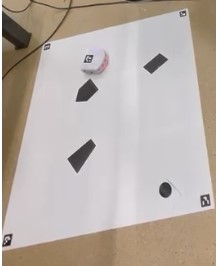

### b) Physical temporary obstacles

- 3D obstacles : 3D objects, assumed to be put sufficiently far away from other 2D-obstacles. The Thymio has to be able to avoid and go round the object without encountering a 2D-obstacle. During tests, we were mainly using water bottles.

## 2. Camera images and computer vision <a class="anchor" id="second-bullet"></a>

## 3. Visibility graph and pathfinding <a class="anchor" id="third-bullet"></a>

To find the path to follow from initial position to the goal, we chose to use the visibility graph technique. It consists in building a graph with : 
- vertices of obstacles, 
- initial position and 
- goal

as nodes, and edges between nodes that are visible from each other. We add weights on the edges, computed as the Euclidian distance between the 2 corresponding vertices.  We then apply Dijkstra's algorithm to find the best path in the resulting weighted graph.

This part is implemented in the function $\texttt{findPath}$ that can be found in file $\texttt{findPath}$. Here below, we go through the main ideas and calculations of the function, and visualize on a similated map. The most interesting results will be displayed as images.  We import the Networkx library for the representation of the graph and Dijkstra's algorithm on these structures. 

#### a) Visualize schematic map and expand the obstacles
In practice, we need to expand the obstacles from half of the total width of the Thymio, to make sure we don't run into these obstacles while moving from vertex to vertex. 

In [2]:
# Needed import for simulation of global path planning
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from drawMaps import plot_map
from processObstacles import expand_obstacles, sort_obstacle_vertices
from VGraph import get_nodes_and_sides, get_edges_and_weights, create_graph
from instructionsCoordinates import get_lengths_and_angles, get_wheretogo_coordinates, get_vertices_from_uniqpoint

In [92]:
# Simulate what we get from computer vision (coordinates in mm)
# Positions can be changed
obs_list = [[[500, 150], [400, 150], [400, 250], [500, 250]],
            [[100, 250], [250, 400], [100, 400]], 
            [[650, 600], [550, 650], [520, 450], [600, 520], [420, 550]]]
robot_dir0 = 0                        # orientation of Thymio, angle between Thymio and horizontal
start_point = [50, 50]              # coordinates of Thymio's reference point (the hole)
goal_point = [800, 750]               # coordinates of the goal point
xLimMap = 850                         # dimensions of the map
yLimMap = 800

In [93]:
# Indicate width of goal and Thymio
width_goal = 20                       # radius of the goal disk
thymio_dimensions = [70, 35, 30, 35]  # forward, left, back, right distance from reference point
# Indicate width to add around obstacles, to ensure not to touch them intentionally
width = 55                            # usually (total Thymio's width)/2

Schematic map :


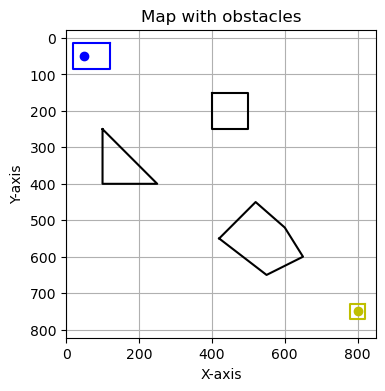

In [94]:
# First processing of the obstacles to make sure vertices are ordered (counterclockwise)
obs_list = sort_obstacle_vertices(obs_list)

# Representing Thymio and goal by their 4 vertices
pos_Thymio = [start_point[0], start_point[1], robot_dir0]
width_goal = width_goal
widths_Thymio = thymio_dimensions
start_pos, goal_pos = get_vertices_from_uniqpoint(goal_point, pos_Thymio, width_goal, widths_Thymio)

# Plot the map with obstacles
print('Schematic map :')
plot_map(obs_list, xLimMap, yLimMap, start=start_pos, start_pt=start_point, goal=goal_pos)

We expand obstacles, making them $\texttt{width}$ bigger. As mentioned above, the obstacles are supposed sufficiently far from each other so that the resulting shapes don't intersect, because their vertices will be used to determine visibility and construct visibility graph.

Schematic map with expanded obstacles :


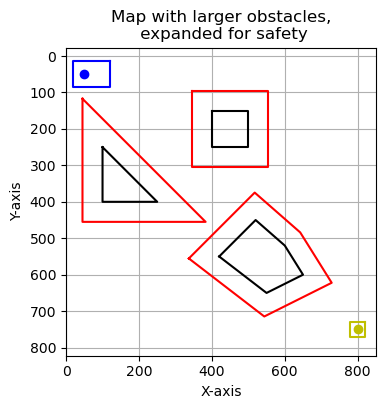

Coordinates of expanded obstacles' vertices : 
 (put together in a list in the code)
 - Obstacle  0
[[345.  95.]
 [345. 305.]
 [555. 305.]
 [555.  95.]]
 - Obstacle  1
[[ 45.  117.2]
 [ 45.  455. ]
 [382.8 455. ]]
 - Obstacle  2
[[336.8 555.4]
 [543.8 714.6]
 [728.7 622.1]
 [642.3 484. ]
 [517.5 374.7]]


In [95]:
# Expand obstacles (ideally by at least half of Thymio robot's width)
expanded_obs = expand_obstacles(obs_list, width) # expanded_obs is now a list of #obs lists of #verticesofthisobs tuples

print('Schematic map with expanded obstacles :')
plot_map(obs_list, xLimMap, yLimMap, True, expanded_obs, start=start_pos, start_pt=start_point, goal=goal_pos)

print("""Coordinates of expanded obstacles' vertices : \n (put together in a list in the code)""")
for obs in range(len(expanded_obs)) :
    print(' - Obstacle ', obs)
    print(*[np.round(expanded_obs[obs], 1)])

These coordinates of the vertices of the expanded obstacles will be part of the output of the $\texttt{findPath}$ function, to plot them on the image from the camera (in live visualisation).

#### b) Construct the visibility graph
We determine whether vertices are visible or not from each other by checking if the segment between them intersects at least one of the edges of the obstacles. If it is the case, these nodes don't see each other. If not, we found a visible node. 

This is the reason why we assumed we had only convex obstacles, because the code doesn't handle visible vertices from the same obstacles.

It may seem unefficient, but it's surprisingly fast, especially when comparing to vision.

Visible vertices from each node :
0 [1, 2, 4, 5, 7]
1 [0, 4, 2, 5]
2 [0, 1, 3, 5, 7, 12]
3 [2, 4, 7, 8, 10, 11, 12, 13]
4 [0, 3, 1, 10, 11, 13]
5 [0, 1, 2, 7, 6]
6 [5, 7, 8, 9]
7 [0, 2, 3, 6, 5, 8, 12]
8 [3, 6, 7, 12, 9]
9 [6, 8, 10, 13]
10 [3, 4, 9, 11, 13]
11 [3, 4, 10, 12]
12 [2, 3, 7, 11, 8]
13 [3, 4, 9, 10]


Map with visibility visualisation :
 (violet lines show visibility relations)


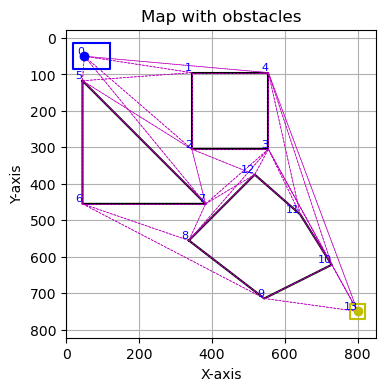

In [96]:
# Get 
# myNodes, nodes' indices (identifiers)
# myVertices, corresponding vertices' coordinates
# mySides, sides of obstacles described by the nodes' indices of the 2 endpoints
myNodes, myVertices, mySides = get_nodes_and_sides(expanded_obs, start_point, goal_point)
        
myEdges, myWeights = get_edges_and_weights(myNodes, myVertices, mySides, verbose=True)

print("Map with visibility visualisation :\n (violet lines show visibility relations)")
plot_map(expanded_obs, xLimMap, yLimMap, larger=False, larger_obs=None, 
     start=start_pos, start_pt=start_point, goal=goal_pos,
     graph=True, graph_edges=myEdges, vertices=myVertices)

Weighted graph :


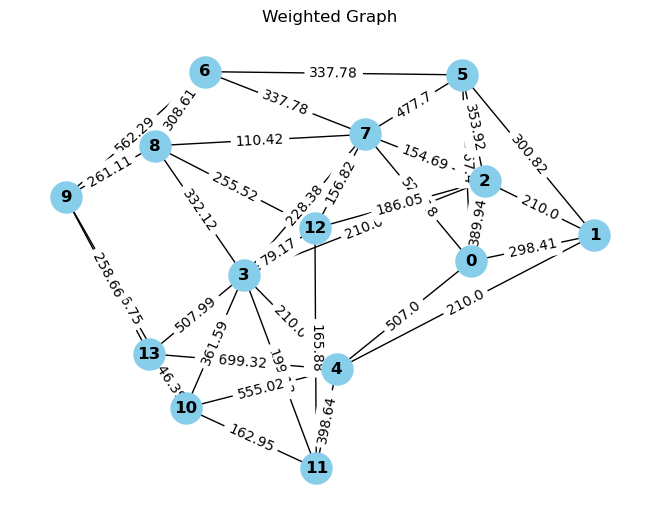

In [97]:
# Visualize the weighted graph. We know it's not possible to find the best path at sight in this graph,
# it's here to illustrate the chosen method.
myGraph = create_graph(myNodes, myEdges, myWeights, verbose=True)

#### c) Find shortest path in graph, using Dijkstra's algorithm

In [98]:
# As said before, we used the already implemented version of the algorithm, from networkx library
myPath = nx.dijkstra_path(myGraph, 0, myNodes[-1][0], weight='weight')
print('Path nodes :', myPath)

Path nodes : [0, 2, 12, 11, 10, 13]


#### d) Convertion from nodes in graph to x,y coordinates :

In [99]:
# Getting coordinates of the points we want to go through
myCoordinates = get_wheretogo_coordinates(myPath, myVertices)
print('Path points coordinates :')
print(myCoordinates)

Path points coordinates :
[[50, 50], [345.0, 305.0], [517.4936034837497, 374.7246505857302], [642.3331586069959, 483.95926131857067], [728.6979342066032, 622.1429022779425], [800, 750]]


## 4. Motion and Thymio's instructions <a class="anchor" id="fourth-bullet"></a>

## 5. Local avoidance <a class="anchor" id="fifth-bullet"></a>

## 6. Filtering <a class="anchor" id="sixth-bullet"></a>

## 7. Complete implementation <a class="anchor" id="seven-bullet"></a>

## 8. Conclusion <a class="anchor" id="eight-bullet"></a>

#### a) Performance analysis
This section aims to assess the robustness of our implementation to certain changes.
- Various lightning : Our code is quite robust to change in lightning because it doesn't use any color detection.
- Various position of camera : The camera doesn't need to be centered on the map (but it needs to see the 4 corners).

#### b) Limitations and potential improvements
- The obstacles are assumed to be convex polygons. With a bit more time, we could adapt the code so that it allows for concave shapes as well. The only part that would require an update is the construction of the visibility graph.

### Appendix : sources <a class="anchor" id="appendix-bullet"></a>
- Visibility graphs : https://www.science.smith.edu/~istreinu/Teaching/Courses/274/Spring98/Projects/Philip/fp/visibility.htm
- Dijkstra algorithm on weighted graph, imported from library networkx : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.dijkstra_path.html
- ChatGPT